# Image classification with MNIST data, with visualization of the results

This notebook shows how to train a convolutional image recognition network for recognizing hand-written digits from the MNIST dataset. This is the "hello world" example of deep learning, and later on we will also have some artistic use for it. 

**Learning goals:**
* Building a simple convolutional neural network
* Useful debugging skills: visualizing errors, visualizing neural network weights

**After you've read, run, and understood the code, try to modify it as follows to test your learning:**

* Easy: try adding 1 or more fully connected layers, e.g., with 64 neurons before the output layer of the fully connected network example. How do the first layer weights look like now?
* Easy: Pass in an artificial image and check what class it is classified into. Hint: you can "paint" rectancles by first creating an empty single image batch as ```image=np.zeros([1,28,28,1])```, and then setting rectangular patches to 1 as ```image[0,y0:y1,x0:x1,0]=1```, where x0,x1,y0,y1 are the rectangle corners. Feel free to also explore more sophisticated drawing methods, e.g., from the skimage library. 
* A bit harder: Visualize the test image (or multiple images) that gives the lowest probability for the correct class. Hint: if you pass a batch of test images to model.predict(), you will get a batch of probabilities back, one vector of 10 probabilities for each image.
* Harder: Visualize how well the network learns features that make the number classes separate. Use principal component analysis (PCA) of the flattened layer outputs, and make a 2D scatterplot of each input image's projection into the 2D subspace defined by the first two principal axes. Numpy provides easy helpers for PCA, just google it up. Do the same for different layer outputs; you should see that the classes overlap less and less as the images pass through the network and training progresses.
* Advanced: Develop a game where the player has to draw images that score high classification probabilities with as few pixels as possible. For this, you should either load the network to Unity using Tensorflow Sharp, or experiment with Python's mouse input etc. Obviously, such interaction is not possible inside Jupyter, so you should develop using some other IDE such as Visual Studio, Pycharm, or Spyder (the latter is included in Anaconda)

As usual, model solutions are provided for the easy exercises, but please try to think of this as a puzzle game where you first try to solve the puzzles yourself and only check out the walkthrough if necessary.

## Loading and visualizing the data

First, let's load the dataset using keras helpers and visualize some images using pyplot

Populating the interactive namespace from numpy and matplotlib
shape:  (60000, 28, 28)
new shape:  (60000, 28, 28, 1)


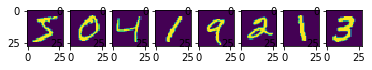

In [8]:
#The pylab inline below is something you may need to make images and plots visible in Jupyter, depending on your Anaconda setup
%pylab inline  
import numpy as np
import matplotlib.pyplot as pp
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" #disable Tensorflow GPU usage, a simple example like this runs faster on CPU
import tensorflow as tf
from tensorflow import keras 

#load the MNIST dataset
mnist = keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

#Scale the pixel intensity values to 0...1 from 0...255
#Fortunately, we don't need a StandardScaler here
x_train, x_test = x_train / 255.0, x_test / 255.0

#check the shape: you should see that x_train is a 3D tensor, 
#with 60000 instances of 2D tensors 28x28 pixels 
print("shape: ",x_train.shape)

#because the keras layers we will use need explicitly defined pixel channel count as the fourth dimension,
#we reshape:
x_train=np.reshape(x_train,[x_train.shape[0],x_train.shape[1],x_train.shape[2],1])
print("new shape: ",x_train.shape)

#do the same for test data
x_test=np.reshape(x_test,[x_test.shape[0],x_test.shape[1],x_test.shape[2],1])


#visualize some of the images
pp.figure(1)
for i in range(8):
    pp.subplot(1,8,1+i)
    #imshow expects a 2d tensor, thus we pick the i:th image, full width and height, and the first and only color channel
    pp.imshow(x_train[i,:,:,0])


# A simple fully connected network model
Before training the convolutional neural network, let's first establish a baseline using a fully connected network similar to what we used in the previous example. 

In [2]:
#Let's import the layer types we need
from tensorflow.keras.layers import Dense   #fully connected layer
from tensorflow.keras.layers import Flatten #converts images to vectors of numbers

#As before, we use a simply sequential, i.e., multilayer architecture
model = keras.models.Sequential()

#Flatten converts a batch of multidimensional data into a batch of 1D data. 
#This is what the fully connected layers expect.
#For example, the rows of an image are simply stacked after each other.
#If the data was not images, we would not need this.
model.add(Flatten())

#The output layer is fully connected, with 1 neuron for each 10 classes.
#For classification, one should use the softmax activation.
#This means that each output neuron can be thought as the probability of a class.
model.add(Dense(10, activation='softmax'))

#Compile the model. We use sparse_categorical_crossentropy loss instead of categorical_crossentropy,
#because the label data contains indices instead of one-hot vectors
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

#Train the network
model.fit(x_train, y_train,
          batch_size=32,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

Instructions for updating:
Colocations handled automatically by placer.
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 45us/sample - loss: 0.4688 - acc: 0.8782 - val_loss: 0.3074 - val_acc: 0.9144

In a fully connected network, the neuron weights are of the same shape as the input. Thus, we can visualize them as images. Below, you should see that a fully connected network does not learn to detect edges, corners etc but instead shapes that correlate with whole input images. This is not very efficient but might be of use in artistic image synthesis.

Because we only have a single layer with a single neuron for each output class, the neuron weight images actually look like numbers. Bright pixels mean large weights, i.e., if the input image has pixels in those areas, the probability of the class corresponding to the neuron will be high. Conversely, dark pixels mean small or negative weighs, i.e., the probability decreases if the input has pixels in those areas. 

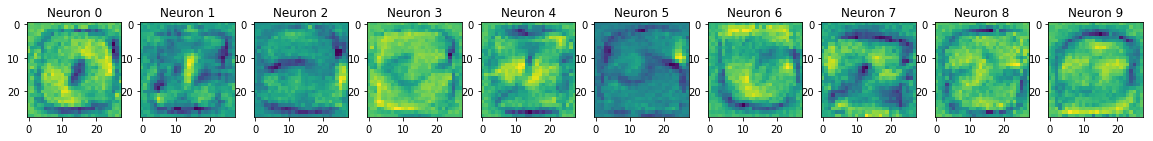

In [3]:
#Visualize some of the first layer neuron weights
#First, query the weights. We use index 1 because index 0 is the flatten layer
weights=model.layers[1].get_weights()[0]
#Create a figure with appropriate size
nNeuronsToVisualize=10
pp.figure(1,figsize=[nNeuronsToVisualize*2,2])
#Loop over the neurons
for i in range(nNeuronsToVisualize):
    #Weights is a 2D tensor where the first dimension indexes over data variables, second over neurons
    image=weights[:,i]
    #We must reshape back to an image
    image=np.reshape(image,[28,28])
    #Now we can display
    pp.subplot(1,nNeuronsToVisualize,1+i)
    pp.title("Neuron {}".format(i))
    pp.imshow(image)  

## A convolutional neural network 

The accuracy of the network trained above is not great. State of the art gets to over 99\% with MNIST data. Even a simple convolutional network will get us much closer to that. Note that this mainly differs from the previous network with respect to the first layers; a convolutional neural network typically ends with a fully connected network, starting with the flatten layer.

Note that this simple Keras model doesn't provide us access to things we will need for many interesting modifications, and we'll later rebuild the same network a bit differently in the [adversarial image generation exercise](AdversarialMNIST.ipynb). However, the code below is a better pedagogical fit for this exercise, as this is the way you've used Keras in the previous examples.

In [4]:
#Let's import the layer types we need
from tensorflow.keras.layers import Dense   #fully connected layer
from tensorflow.keras.layers import Conv2D  #convolutional layer with 2D filters (for audio you would use 1D)
from tensorflow.keras.layers import Dropout #this mitigates overfitting

#As before, we use a simply sequential, i.e., multilayer architecture
model = keras.models.Sequential()

#Instead of using fully connected layers like before, we use convolutional ones.
#We use 5x5 pixel features, and use strides of 2x2 to drop resolution by a factor of 2 after each layer
model.add(Conv2D(16, kernel_size=(5, 5), strides=[2,2],
                 activation='relu',
                 input_shape=(28,28,1,)))
model.add(Conv2D(32, (5, 5), activation='relu', strides=[2,2]))
#After the previous two layers, we are at 7x7 pixel resolution instead of the original 28x28 pixels.
#Thus, 5x5 filters would not be meaningful, as they would encompass almost the whole images
model.add(Conv2D(32, (3, 3), activation='relu', strides=[2,2]))

#Now, we are at 3x3 pixel resolution and there's no point in doing convolutions anymore.
#Instead, we'll just add a small fully connected layer just like above
#Again, we first need to flatten from a batch of images to a batch of 1D tensors
model.add(Flatten())
#Some regularization
model.add(Dropout(0.5))
#One fully connected
model.add(Dense(32, activation='relu'))
#More regularization
model.add(Dropout(0.5))
#Last fully connected layer, with softmax activation, which is what one needs for classification.
#Softmax means that each output neuron can be thought as the probability of a class.
#We use 10 neurons because MNIST has 10 classes.
model.add(Dense(10, activation='softmax'))

#Compile the model. We use sparse_categorical_crossentropy loss instead of categorica_crossentropy,
#because the label data contains indices instead of one-hot vectors
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

#Train the network
model.fit(x_train, y_train,
          batch_size=32,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 11s 189us/sample - loss: 1.0225 - acc: 0.6499 - val_loss: 0.2621 - val_acc: 0.9402

Let's test the classifier with an images. 

Testing with image:


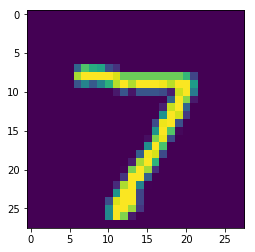

Predicted class probabilities:  [[3.1212148e-14 1.6445136e-14 2.1771283e-09 5.6882840e-12 2.8938720e-15
  1.2791610e-15 3.8051342e-19 1.0000000e+00 3.4598558e-21 3.4779363e-11]]
Most probable class is 7, with probability 1.0


In [5]:
#this is the test image
testIdx=0
#Show the image
print("Testing with image:")
pp.imshow(x_test[testIdx,:,:,0])
pp.show()
#We index by testIdx:testIdx+1 to pass a batch of one image to the network instead of just one image
classProbabilities=model.predict(x_test[testIdx:testIdx+1])
print("Predicted class probabilities: ",classProbabilities)
#np.argmax returns the index of the largest value in a Numpy tensor.
#np.max returns the largest value
print("Most probable class is {}, with probability {}".format(np.argmax(classProbabilities),np.max(classProbabilities)))


Now, let's try to see what the network has learned. Research shows that the first layer of a convolutional image classification network should learn something like detectors for oriented edges or similar simple features.

Visualizing layer 0 kernel, shape (5, 5, 1, 16)


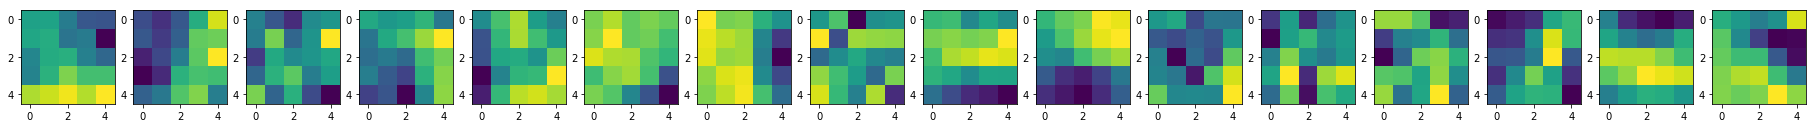

In [6]:
#Define a visualization helper

def visualizeLayerWeights(model,layerIndex):
    #Get the neuron weights, i.e., convolution kernels or filters
    kernel=model.layers[layerIndex].get_weights()[0]
    #Check the shape
    print("Visualizing layer {} kernel, shape {}".format(layerIndex,kernel.shape))
    #Visualize 16 first filters
    nFiltersToVisualize=16
    pp.figure(1,figsize=[nFiltersToVisualize*2,2])  #specify figsize explicitly because otherwise the images will be too small
    for i in range(nFiltersToVisualize):
        pp.subplot(1,nFiltersToVisualize,1+i)
        pp.imshow(kernel[:,:,0,i])
    pp.show()
    
#visualize first layer
visualizeLayerWeights(model,0)
        
